# Salary Predictions Based on Job Descriptions

## Problem Statment 

Predict the salary of an individual using data about prior individuals and their qualifications

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

__author__ = "Vijay Raj Saravanan Radhakrishnan"
__email__ = "vijay_saravanan@outlook.com"

## Part 2 - DISCOVER

In [2]:
#load the data into a Pandas dataframe
feature_data = pd.read_csv("data/train_features.csv")
target_data = pd.read_csv("data/train_salaries.csv")
Total_data = pd.merge(feature_data, target_data, how="inner", on="jobId")
train, test = train_test_split(Total_data, test_size = 0.2)


In [3]:
train.shape

(800000, 9)

In [4]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 331972 to 823307
Data columns (total 9 columns):
jobId                  800000 non-null object
companyId              800000 non-null object
jobType                800000 non-null object
degree                 800000 non-null object
major                  800000 non-null object
industry               800000 non-null object
yearsExperience        800000 non-null int64
milesFromMetropolis    800000 non-null int64
salary                 800000 non-null int64
dtypes: int64(3), object(6)
memory usage: 61.0+ MB


In [5]:
train.describe()

,yearsExperience,milesFromMetropolis,salary
count,800000.000000,800000.000000,800000.000000
mean,11.992190,49.536056,116.074335
std,7.210395,28.874983,38.744174
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [6]:
train.describe(include=["O"])

,jobId,companyId,jobType,degree,major,industry
count,800000,800000,800000,800000,800000,800000
unique,800000,63,8,5,9,7
top,JOB1362685338016,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,12885,100496,189623,425707,114600


### ---- 3 Clean the data ----

In [7]:
train.duplicated().sum()

0

In [8]:
def standard_column_names(df):
    existing_columns = list(df.columns.values)
    standardized_names = [column_name.lower() for column_name in existing_columns]
    df.columns = standardized_names

In [9]:
categ_features = ["companyid", "jobtype", "degree", "major", "industry"]
num_features = ["milesfrommetropolis", "yearsexperience"]
def convert_to_category(df):
    for cat_feature in categ_features:
        df[cat_feature] = df[cat_feature].astype("category")


In [10]:
standard_column_names(train)
standard_column_names(test)
convert_to_category(train)
convert_to_category(test)

### ---- 4 Explore the data (EDA) ----

In [11]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features
def visualize_relationship(df, feature):
    if df[feature].dtype.name == "category":
        if feature == "companyId":
            pass
        elif feature == "salary":
            plt.hist(df[feature])
            plt.xlabel("Salary")
            plt.ylabel("Frequency")
        else:
            plt.figure(figsize=(16,8))
            plt.subplot(121)
            sb.countplot(data=df, x=feature)
            plt.xlabel(feature.capitalize())
            plt.ylabel("Frequency")
            plt.xticks(rotation=45)
            
            plt.subplot(122)
            sb.boxplot(df[feature], df["salary"])
            plt.xticks(rotation = 45)
            
                         
    if df[feature].dtype.name == "int64":
        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        plt.hist(df[feature])
        plt.xlabel(feature.capitalize())
        plt.ylabel("Frequency")
        
        plt.subplot(122)
        plt.scatter(df[feature], df["salary"], alpha=0.2)
        plt.xlabel(feature.capitalize())
        plt.ylabel("Salary")
        plt.title("{} vs {}".format("Salary", feature.capitalize()))

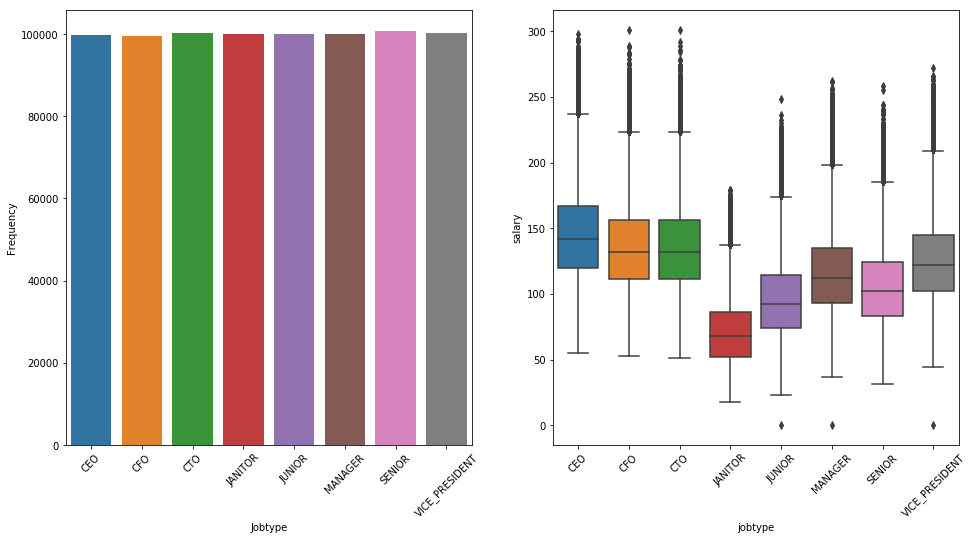

In [12]:
visualize_relationship(train, "jobtype")

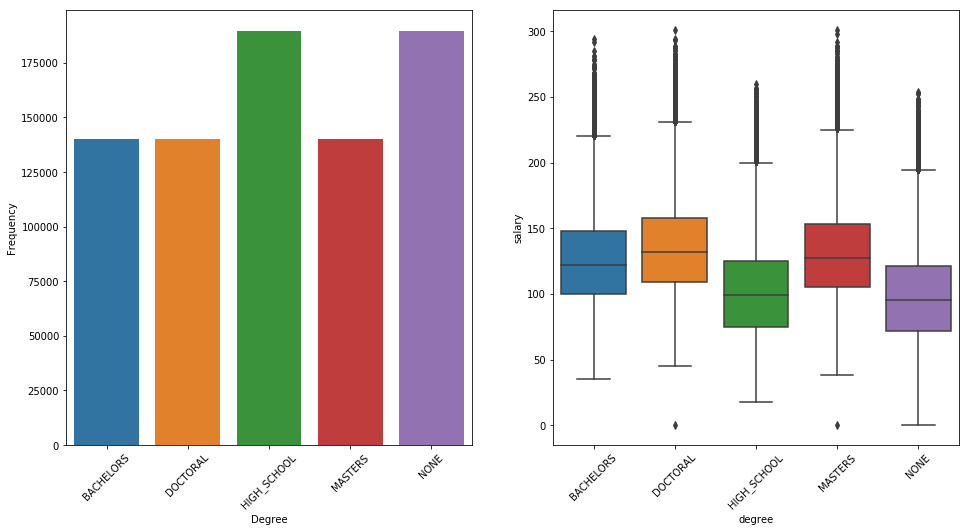

In [13]:
visualize_relationship(train, "degree")

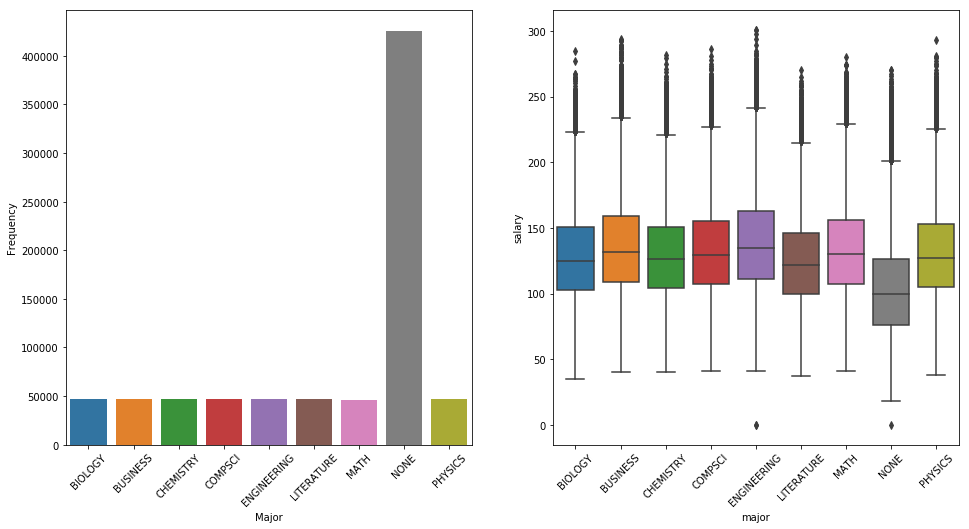

In [14]:
visualize_relationship(train, "major")

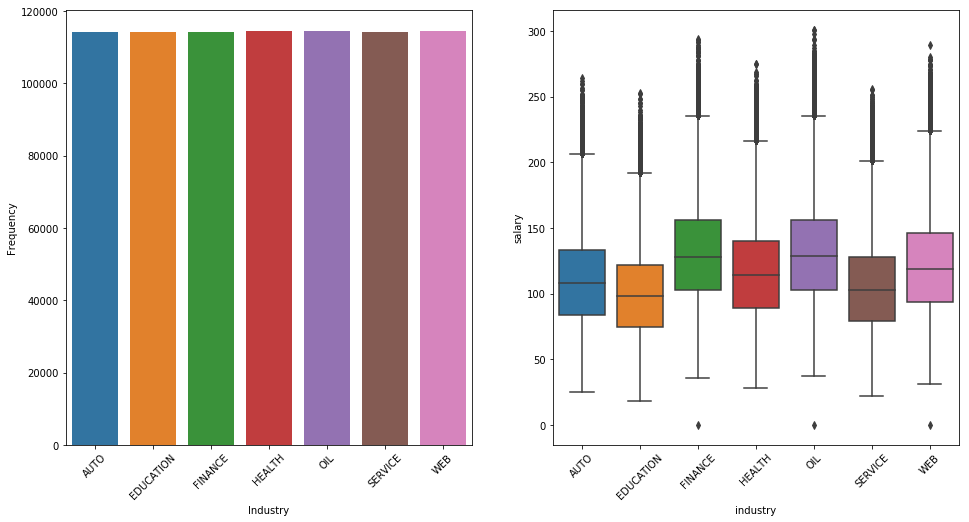

In [15]:
visualize_relationship(train, "industry")

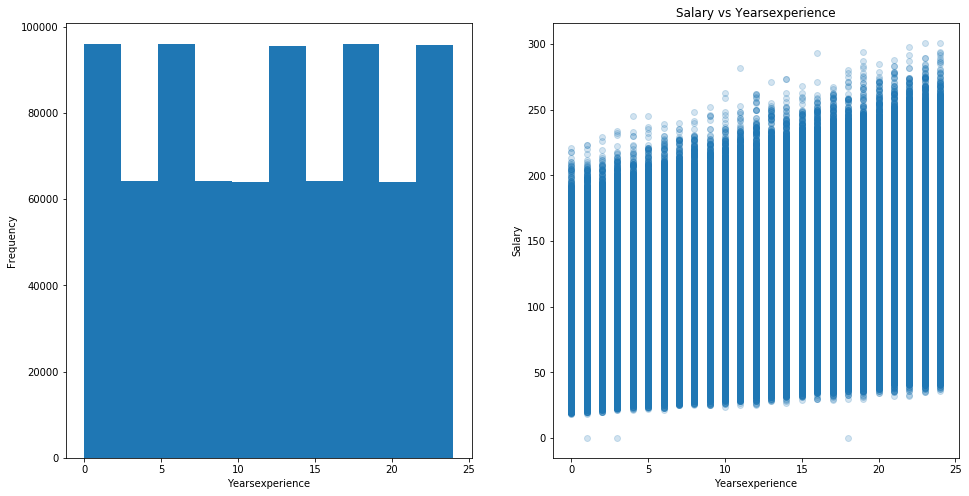

In [16]:
visualize_relationship(train, "yearsexperience")

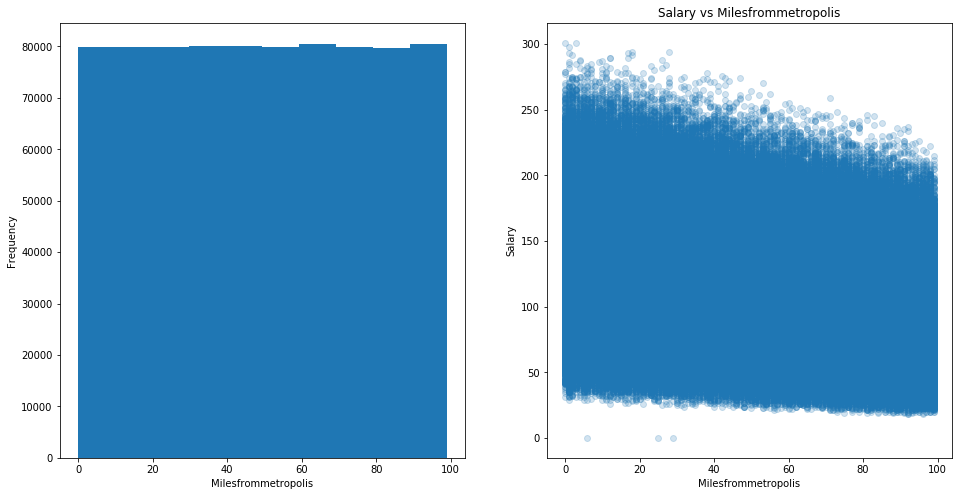

In [17]:
visualize_relationship(train, "milesfrommetropolis")

## Pipeline

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, df):
        return df[self.attributes].values

num_pipeline = Pipeline([("selector", DataFrameSelector(num_features)),
                        ("std_scaler", StandardScaler())])
cat_pipeline = Pipeline([("selector", DataFrameSelector(categ_features)),
                        ("one_hot_encoder", OneHotEncoder())])

final_pipeline = FeatureUnion(transformer_list=[("numerial_pipeline", num_pipeline),
                                               ("categorical_pipeline", cat_pipeline)])


In [12]:
Xtrain = train.iloc[:, 1:-1].copy()
ytrain = train.iloc[:,[-1]].copy()
Xtest = test.iloc[:, 1:-1].copy()
ytest = test.iloc[:,[-1]].copy()

Xtrain = final_pipeline.fit_transform(Xtrain)
Xtest = final_pipeline.fit_transform(Xtest)

### Linear Regression

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
predicted = lin_reg.predict(Xtest)

mse = mean_squared_error(ytest, predicted)
print(mse)

383.64278381099007


In [14]:
lin_reg_scores = cross_val_score(lin_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
lin_reg_scores = np.negative(lin_reg_scores)
print(lin_reg_scores)
print("Mean: {}".format(np.mean(lin_reg_scores)))
print("Standard Deviation: {}".format(np.std(lin_reg_scores)))

[383.93812832 385.64551788 386.17568816 382.78082909 385.24157453]
Mean: 384.7563475974375
Standard Deviation: 1.2339167531930715


### Stochastic Gradient Descent Regressor

In [15]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter = 50, eta0=0.01)
sgd_reg.fit(Xtrain, ytrain)
sgd_predicted = sgd_reg.predict(Xtest)

sgd_mse = mean_squared_error(ytest, sgd_predicted)
print(sgd_mse)

383.78332057100897


#### Stochastic Gradient Descent Regressor - Cross Validation

In [16]:
sgd_reg_scores = cross_val_score(sgd_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
sgd_reg_scores = np.negative(sgd_reg_scores)
print("Mean: {}".format(np.mean(sgd_reg_scores)))
print("Standard Deviation: {}".format(np.std(sgd_reg_scores)))

Mean: 384.85699443929224
Standard Deviation: 1.2487340054664202


### Ridge Regression

In [17]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.5, solver="cholesky")
ridge_reg.fit(Xtrain, ytrain)
ridge_predicted = ridge_reg.predict(Xtest)
ridge_mse = mean_squared_error(ytest, ridge_predicted)
print(ridge_mse)

383.644440398911


#### Ridge Regression - Cross Validation

In [18]:
ridge_reg_scores = cross_val_score(ridge_reg, Xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
ridge_reg_scores = np.negative(ridge_reg_scores)
print(ridge_reg_scores)
print("Mean: {}".format(np.mean(ridge_reg_scores)))
print("Standard Deviation: {}".format(np.std(ridge_reg_scores)))

[383.93833563 385.64737133 386.17207869 382.78251234 385.24010497]
Mean: 384.7560805926199
Standard Deviation: 1.2326725339517943


### Adding polynomial features to the data set

In [14]:
from sklearn.preprocessing import PolynomialFeatures
num_pipeline_poly = Pipeline([("selector", DataFrameSelector(num_features)),
                        ("std_scaler", StandardScaler()),
                        ("polynomial", PolynomialFeatures(degree=2, include_bias=True))])

final_pipeline_poly = FeatureUnion(transformer_list=[("numerial_pipeline", num_pipeline_poly),
                                               ("categorical_pipeline", cat_pipeline)])

In [15]:
Xtrain_poly = final_pipeline_poly.fit_transform(train)
Xtest_poly = final_pipeline_poly.fit_transform(test)
lin_reg.fit(Xtrain_poly, ytrain)
predicted = lin_reg.predict(Xtest_poly)

mse_poly = mean_squared_error(ytest, predicted)
print(mse_poly)

### SGD Regression with polynomial features

In [22]:
from sklearn.linear_model import SGDRegressor
sgd_reg_poly = SGDRegressor()
sgd_reg_poly.fit(Xtrain_poly, ytrain)
sgd_predicted = sgd_reg_poly.predict(Xtest_poly)

sgd_poly_mse = mean_squared_error(ytest, sgd_predicted)
print(sgd_poly_mse)

366.42010458909414


### Ridge Regression with polynomial features

In [16]:
from sklearn.linear_model import Ridge
ridge_reg_poly = Ridge(alpha=0.5, solver="cholesky")
ridge_reg_poly.fit(Xtrain_poly, ytrain)
ridge_poly_predicted = ridge_reg_poly.predict(Xtest_poly)
ridge_mse = mean_squared_error(ytest, ridge_poly_predicted)
print(ridge_mse)

365.63503941104716


### Decision Tree Regressor with polynomial features

In [27]:
from sklearn.tree import DecisionTreeRegressor
dec_tree_poly = DecisionTreeRegressor()
dec_tree_poly.fit(Xtrain_poly, ytrain)
dec_poly_predictions = dec_tree_poly.predict(Xtest_poly)
dec_poly_mse = mean_squared_error(ytest, dec_poly_predictions)
print(dec_poly_mse)

709.4835784722221


## Cross Validation

In [23]:
print("Cross validation for SGD Regression with polynomial features")
sgd_poly_scores = cross_val_score(sgd_reg_poly, Xtrain_poly, ytrain, scoring="neg_mean_squared_error", cv=5)
print(sgd_poly_scores)
print("Mean: {}".format(np.mean(sgd_poly_scores)))
print("Standard Deviation: {}".format(np.std(sgd_poly_scores)))

[-367.28175808 -370.72999719 -369.76420866 -367.41391856 -368.96937529]
Mean: -368.83185155607714
Standard Deviation: 1.3345023913414855


In [26]:
print("Cross validation for Ridge Regression with polynomial features")
ridge_poly_scores = cross_val_score(ridge_reg_poly, Xtrain_poly, ytrain, scoring="neg_mean_squared_error", cv=5)
print(ridge_poly_scores)
print("Mean: {}".format(np.mean(ridge_poly_scores)))
print("Standard Deviation: {}".format(np.std(ridge_poly_scores)))


[-366.40632359 -367.75232237 -368.87887547 -366.40541956 -368.2310523 ]
Mean: -367.53479865786915
Standard Deviation: 0.9886942185895301


## Final Model

By adding polynomial features, the mean squared error was reduced to 366 from 383. The final model that is being chosen in Ridge Regression model with a Mean Squared Error(MSE) of `367`.

In [17]:
from sklearn.externals import joblib
joblib.dump(ridge_reg_poly, "my_model.pkl")

['my_model.pkl']

## Part 3 - DEVELOP

### ---- 10 Select best model  ----

In [31]:
ml_model = joblib.load("my_model.pkl")
test_features = pd.read_csv("data/test_features.csv")
processed_test = final_pipeline_poly.fit_transform(processed_test)
model_results = ml_model.predict(processed_test)
pd.to_csv()

## Part 4 - DEPLOY

### ---- 12 Deploy solution ----

In [33]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders


### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data